# Wikimedia dataset analysis and preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load data
data = pd.read_csv("train_tarea_recsys_2019.csv")
data.head()

,user,image_id,timestamp
0,1,200502005,1108503300
1,1,200504028,1113243060
2,1,200504029,1113243060
3,1,200504034,1113246480
4,1,200504035,1113246600


## Interactions data

In [3]:
print("Interactions shape", data.shape)

Interactions shape (96533, 3)


There are 96533 rows in the data file, where only possitive feedback is considered. But first, some user-item interactions are repeated, and we'll consider only the last one.

In [4]:
# Sort by timestamp
data = data.sort_values(by="timestamp", ascending=True)

In [5]:
# Keep latest interaction between user-item pairs
data = data.groupby(["user", "image_id"]).tail(1).reset_index(drop=True)

In [6]:
print("Interactions shape", data.shape)

Interactions shape (95922, 3)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95922 entries, 0 to 95921
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user       95922 non-null  int64
 1   image_id   95922 non-null  int64
 2   timestamp  95922 non-null  int64
dtypes: int64(3)
memory usage: 2.2 MB


In [8]:
data.head()

,user,image_id,timestamp
0,30,200501002,1105490700
1,12,200501002,1105521180
2,31,200501002,1105568700
3,6,200501002,1105646820
4,14,200501002,1105738260


In [9]:
data.describe()

,user,image_id,timestamp
count,95922.000000,9.592200e+04,9.592200e+04
mean,3470.641667,2.013686e+08,1.391965e+09
std,2045.785655,3.682406e+05,1.162497e+08
min,1.000000,2.005010e+08,1.105491e+09
25%,1736.000000,2.011050e+08,1.303837e+09
50%,3714.000000,2.015030e+08,1.424783e+09
75%,5049.000000,2.017012e+08,1.485018e+09
max,7395.000000,2.019042e+08,1.556338e+09


Sort and reset index. Also drop score column.

In [10]:
data = data.sort_values(by="timestamp", ascending=True)
# data = data.drop(["score"], axis=1)
data = data.reset_index(drop=True)
data.head()

,user,image_id,timestamp
0,30,200501002,1105490700
1,12,200501002,1105521180
2,31,200501002,1105568700
3,6,200501002,1105646820
4,14,200501002,1105738260


**How many users and items left?** Some may have been dropped, so let's count again:

In [11]:
print("Users:", data["user"].nunique())
print("Items:", data["image_id"].nunique())

Users: 1079
Items: 9636


**Maximum number of interactions at the same time?** Sometimes this happens

In [12]:
# No idea how (or why)
data.groupby(["timestamp"]).count().max()

user        21
image_id    21
dtype: int64

**Number of interactions per item?**

In [13]:
items = data.groupby(["image_id"]).count()["user"]
items.describe()

count    9636.000000
mean        9.954545
std         4.338889
min         2.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        34.000000
Name: user, dtype: float64

**Most active items?**

In [14]:
most_active_items = items.sort_values(ascending=False)
most_active_items.head()

image_id
201707149    34
201812099    30
201901175    30
201804142    30
201204203    30
Name: user, dtype: int64

In [15]:
N = 964  # 10%
interactions_by_active_items = most_active_items[:N].sum() / items.sum() * 100
print(f"{interactions_by_active_items:.2f} % of interactions comes from the top {N} most active items")

19.29 % of interactions comes from the top 964 most active items


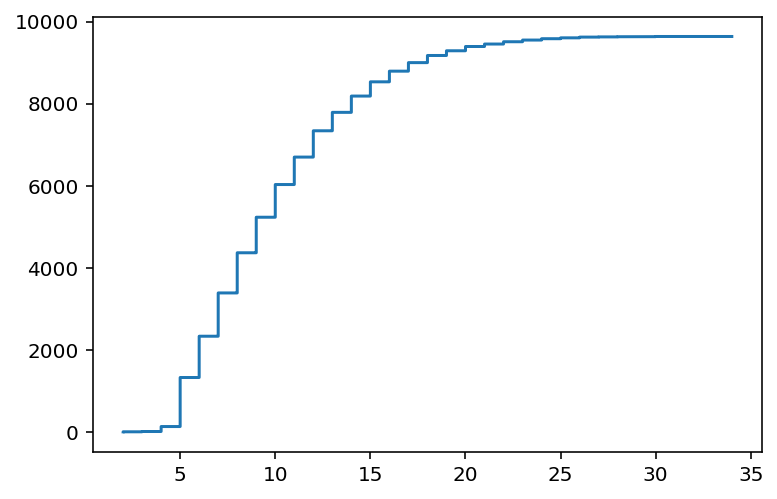

In [16]:
sorted_data = np.sort(most_active_items)
plt.step(sorted_data, np.arange(sorted_data.size))
plt.show()

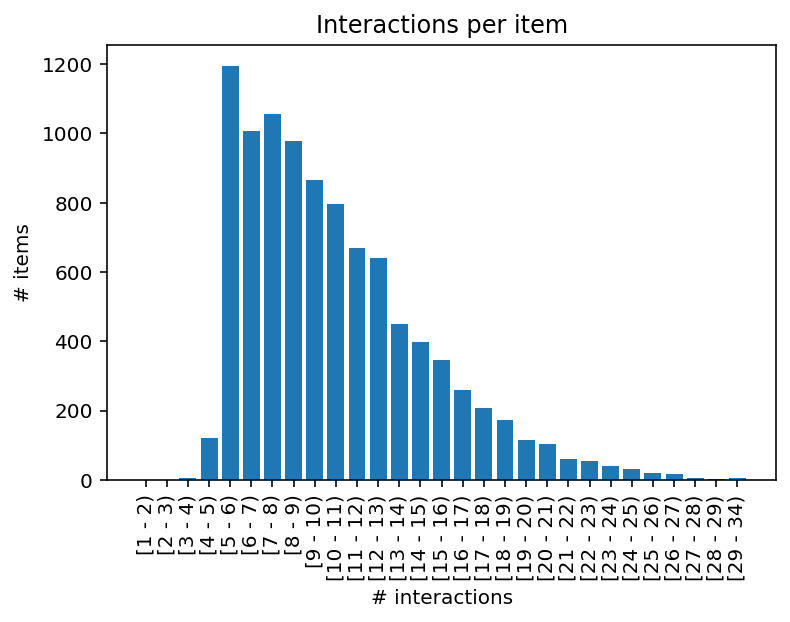

In [17]:
bins = list(range(1, 30)) + [items.max()]

hist, bins = np.histogram(items, bins)
x_axis = np.arange(0, len(hist))
plt.bar(x_axis, hist)
bin_names = [f"[{bins[i]} - {bins[i+1]})" for i in range(len(hist))]
plt.xticks(x_axis, bin_names, rotation=90)

# Title and labels
plt.title("Interactions per item")
plt.xlabel("# interactions")
plt.ylabel("# items")
plt.show()

**Number of interactions per user?**

In [18]:
users = data.groupby(["user"]).count()["image_id"]
users.describe()

count    1079.000000
mean       88.898981
std       259.067935
min         3.000000
25%         7.000000
50%        15.000000
75%        52.000000
max      3543.000000
Name: image_id, dtype: float64

**Most active users?**

In [19]:
most_active_users = users.sort_values(ascending=False)
most_active_users.head()

user
2524    3543
4605    3005
2133    2608
5907    2251
5607    1970
Name: image_id, dtype: int64

In [20]:
N = 108  # 10%
interactions_by_active_users = most_active_users[:N].sum() / users.sum() * 100
print(f"{interactions_by_active_users:.2f} % of interactions comes from the top {N} most active users")

70.53 % of interactions comes from the top 108 most active users


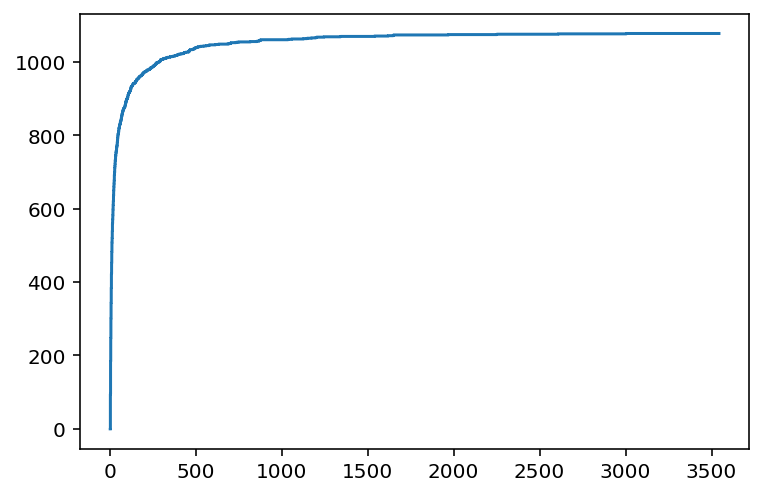

In [21]:
sorted_data = np.sort(most_active_users)
plt.step(sorted_data, np.arange(sorted_data.size))
plt.show()

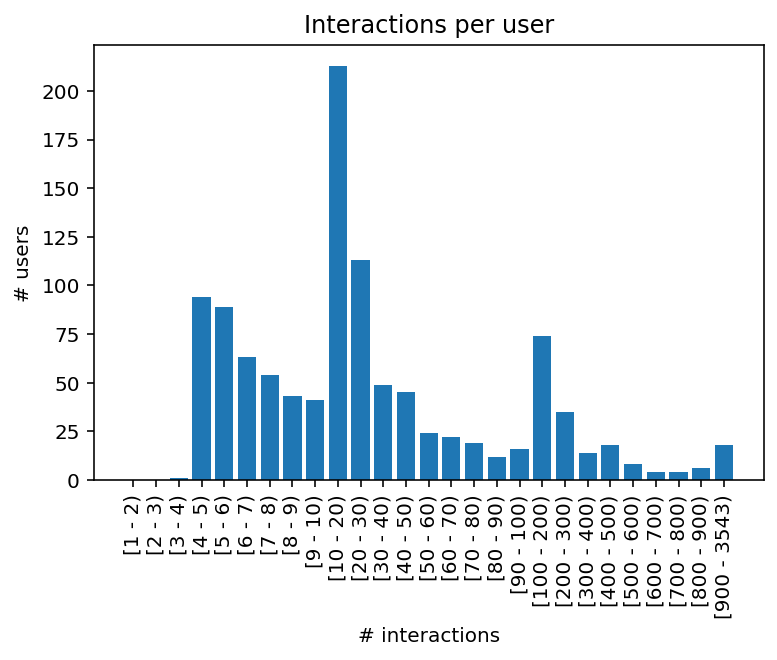

In [22]:
bins = (
    list(range(1, 10))
    + [10*i for i in range(1, 10)]
    + [100*i for i in range(1, 10)]
    + [users.max()]
)

hist, bins = np.histogram(users, bins)
x_axis = np.arange(0, len(hist))
plt.bar(x_axis, hist)
bin_names = [f"[{bins[i]} - {bins[i+1]})" for i in range(len(hist))]
plt.xticks(x_axis, bin_names, rotation=90)

# Title and labels
plt.title("Interactions per user")
plt.xlabel("# interactions")
plt.ylabel("# users")
plt.show()

## Output

In [23]:
n_users = data["user"].nunique()
n_items = data["image_id"].nunique()
n_items_gt = 32958
print(f"Unique users: {n_users}")
print(f"Unique items: {n_items_gt}")
print(f"Unique items 'interacted': {n_items}")
print(f"Interactions per user: {users.mean()} +/- {users.std()}")
actual_mean = items.sum() / n_items_gt
actual_std = np.sqrt(np.mean(np.abs(items - actual_mean)**2))
print(f"Interactions per item: {actual_mean} +/- {actual_std}") 
print(f"Interactions per 'interacted' item: {items.mean()} +/- {items.std()}")
possible_interactions = n_users * n_items_gt
print(f"Possible interactions: {possible_interactions}")
print(f"Sparsity: {100 * len(data) / possible_interactions:2f}%")

Unique users: 1079
Unique items: 32958
Unique items 'interacted': 9636
Interactions per user: 88.89898053753475 +/- 259.0679347099485
Interactions per item: 2.910431458219552 +/- 8.273061391395128
Interactions per 'interacted' item: 9.954545454545455 +/- 4.338888855833803
Possible interactions: 35561682
Sparsity: 0.269734%


In [24]:
data

,user,image_id,timestamp
0,30,200501002,1105490700
1,12,200501002,1105521180
2,31,200501002,1105568700
3,6,200501002,1105646820
4,14,200501002,1105738260
...,...,...,...
95917,6115,201904242,1556273400
95918,6115,201904235,1556273520
95919,2738,201904235,1556319360
95920,2738,201904242,1556319720


In [25]:
data = data.rename(columns={
    "user": "user_id",
    "image_id": "item_id",
})
data = data[["user_id", "item_id", "timestamp"]]
data = data.sort_values("timestamp")
data = data.reset_index(drop=True)

In [26]:
data.to_csv("wikimedia.csv", index=False)

In [27]:
data

,user_id,item_id,timestamp
0,30,200501002,1105490700
1,12,200501002,1105521180
2,31,200501002,1105568700
3,6,200501002,1105646820
4,14,200501002,1105738260
...,...,...,...
95917,6115,201904242,1556273400
95918,6115,201904235,1556273520
95919,2738,201904235,1556319360
95920,2738,201904242,1556319720
